In [1]:
# Jupyter notebook magic to reload modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append(
    "../",
)  # path to the src with the functions

## Select a file + trial from the dataset


In [3]:
import pickle

# Path to the pickle file
pkl_path_1 = "../data/Data05_External_noise/gna_1.00_gk_1.00_noise_1.00/00.pkl"  # Baseline at 20X external input

# Load the pickle file
# load path 1
try:
    with open(pkl_path_1, "rb") as file:
        data = pickle.load(file)
    print("Data loaded successfully.")
except Exception as e:
    print("Error loading the file:", e)

--No graphics will be displayed.


numprocs=1


Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified


Data loaded successfully.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from src.SanjayCode import find_depolarization_block
from scipy.ndimage import gaussian_filter1d

## Find DPB onset


In [5]:
# Calculate the DPB onset in basket cells
cell_range = range(800, 1000)  # Basket cells GID range
depolarization_onset = find_depolarization_block(data["simData"], cell_range)

if depolarization_onset is not None:
    print(f"Depolarization block onset detected at {depolarization_onset} ms")
else:
    print("No depolarization block detected.")

Depolarization block onset detected at 848.6 ms


## Burst detection (last before and 1st after DPB)


In [6]:
def detect_bursts(activity, threshold):
    """
    Detects bursts in the convolved activity based on a fixed threshold.
    Returns the indices of the start and end of bursts.
    """
    above_threshold = activity > threshold
    diff = np.diff(above_threshold.astype(int))
    start_indices = np.where(diff == 1)[0] + 1  # Start of burst
    end_indices = np.where(diff == -1)[
        0
    ]  # End of burst if activity ends exactly at threshold

    # Adding handling for bursts that might start at the beginning or end at the end of the activity array
    if above_threshold[0]:
        start_indices = np.insert(start_indices, 0, 0)  # If starts with a burst
    if above_threshold[-1]:
        end_indices = np.append(end_indices, len(activity) - 1)  # If ends with a burst

    valid_bursts = [
        (start, end)
        for start, end in zip(start_indices, end_indices)
        if end - start
        >= 3  # Ensuring the burst lasts for at least the duration of 3 bins
    ]
    return valid_bursts

In [7]:
def convolve_spike_activity_DPB_with_bursts(
    simData, depolarization_onset, window=200, resolution=1, sigma=1, fixed_threshold=1
):
    gids = {"Pyr": range(800), "Bwb": range(800, 1000)}
    time_bins = np.arange(
        depolarization_onset - window,
        depolarization_onset + window + resolution,
        resolution,
    )

    convolved_activities = {}
    burst_info = {}

    for cell_type, gid_range in gids.items():
        spike_times = np.concatenate(
            [simData[gid].spike_times for gid in gid_range if gid in simData]
        )
        spike_counts, _ = np.histogram(spike_times, bins=time_bins)
        convolved_activity = gaussian_filter1d(spike_counts, sigma=sigma / resolution)

        bursts = detect_bursts(convolved_activity, fixed_threshold)

        last_burst_before_dpb = None
        second_last_burst_before_dpb = None
        first_burst_after_dpb = None
        for start, end in bursts:
            if time_bins[start] < depolarization_onset:
                second_last_burst_before_dpb = last_burst_before_dpb
                last_burst_before_dpb = (start, end, max(convolved_activity[start:end]))
            elif (
                time_bins[start] > depolarization_onset
                and first_burst_after_dpb is None
            ):
                first_burst_after_dpb = (start, end, max(convolved_activity[start:end]))
                break  # Stop after finding the first burst after DPB

        # Adjusting the tuple values to time bins for consistency
        if last_burst_before_dpb is not None:
            last_burst_before_dpb = (
                time_bins[last_burst_before_dpb[0]],
                time_bins[last_burst_before_dpb[1]],
                last_burst_before_dpb[2],
            )
        if second_last_burst_before_dpb is not None:
            second_last_burst_before_dpb = (
                time_bins[second_last_burst_before_dpb[0]],
                time_bins[second_last_burst_before_dpb[1]],
                second_last_burst_before_dpb[2],
            )
        if first_burst_after_dpb is not None:
            first_burst_after_dpb = (
                time_bins[first_burst_after_dpb[0]],
                time_bins[first_burst_after_dpb[1]],
                first_burst_after_dpb[2],
            )

        convolved_activities[cell_type] = (time_bins[:-1], convolved_activity)
        burst_info[cell_type] = {
            "last_burst_before_dpb": last_burst_before_dpb,
            "second_last_burst_before_dpb": second_last_burst_before_dpb,
            "first_burst_after_dpb": first_burst_after_dpb,
        }

    # Return the convolved activities, burst information
    return convolved_activities, burst_info

In [8]:
convolved_activities, burst_info = convolve_spike_activity_DPB_with_bursts(
    data["simData"], depolarization_onset
)

In [9]:
print(convolved_activities, burst_info)

{'Pyr': (array([ 648.6,  649.6,  650.6,  651.6,  652.6,  653.6,  654.6,  655.6,
        656.6,  657.6,  658.6,  659.6,  660.6,  661.6,  662.6,  663.6,
        664.6,  665.6,  666.6,  667.6,  668.6,  669.6,  670.6,  671.6,
        672.6,  673.6,  674.6,  675.6,  676.6,  677.6,  678.6,  679.6,
        680.6,  681.6,  682.6,  683.6,  684.6,  685.6,  686.6,  687.6,
        688.6,  689.6,  690.6,  691.6,  692.6,  693.6,  694.6,  695.6,
        696.6,  697.6,  698.6,  699.6,  700.6,  701.6,  702.6,  703.6,
        704.6,  705.6,  706.6,  707.6,  708.6,  709.6,  710.6,  711.6,
        712.6,  713.6,  714.6,  715.6,  716.6,  717.6,  718.6,  719.6,
        720.6,  721.6,  722.6,  723.6,  724.6,  725.6,  726.6,  727.6,
        728.6,  729.6,  730.6,  731.6,  732.6,  733.6,  734.6,  735.6,
        736.6,  737.6,  738.6,  739.6,  740.6,  741.6,  742.6,  743.6,
        744.6,  745.6,  746.6,  747.6,  748.6,  749.6,  750.6,  751.6,
        752.6,  753.6,  754.6,  755.6,  756.6,  757.6,  758.6,  759.

In [10]:
def plot_convolved_activities_and_bursts(
    convolved_activities, burst_info, depolarization_onset
):
    """
    Plots the convolved spike activities and highlights the detected bursts, along with depolarization onset.

    Parameters:
    convolved_activities (dict): A dictionary with cell populations as keys and tuples of (time_bins, convolved_activity) as values.
    burst_info (dict): A dictionary with cell populations as keys and burst information as values.
    depolarization_onset (float): The time point of depolarization onset, now passed as a standalone parameter.
    """
    plt.figure(figsize=(12, 8))

    for cell_type, (time_bins, activity) in convolved_activities.items():
        plt.plot(time_bins, activity, label=f"{cell_type} Activity")

        # Highlight second-to-last burst before DPB if present
        if (
            cell_type in burst_info
            and "second_last_burst_before_dpb" in burst_info[cell_type]
        ):
            if burst_info[cell_type]["second_last_burst_before_dpb"]:
                t_on, t_off, peak = burst_info[cell_type][
                    "second_last_burst_before_dpb"
                ]
                plt.axvspan(
                    t_on,
                    t_off,
                    color="blue",
                    alpha=0.3,
                    label=f"{cell_type} Second-to-Last Burst Before DPB",
                )

        # Highlight last burst before DPB if present
        if cell_type in burst_info and "last_burst_before_dpb" in burst_info[cell_type]:
            if burst_info[cell_type]["last_burst_before_dpb"]:
                t_on, t_off, peak = burst_info[cell_type]["last_burst_before_dpb"]
                plt.axvspan(
                    t_on,
                    t_off,
                    color="orange",
                    alpha=0.3,
                    label=f"{cell_type} Last Burst Before DPB",
                )

        # Highlight first burst after DPB if present
        if cell_type in burst_info and "first_burst_after_dpb" in burst_info[cell_type]:
            if burst_info[cell_type]["first_burst_after_dpb"]:
                t_on, t_off, peak = burst_info[cell_type]["first_burst_after_dpb"]
                plt.axvspan(
                    t_on,
                    t_off,
                    color="green",
                    alpha=0.3,
                    label=f"{cell_type} First Burst After DPB",
                )

    # Add a red vertical line for the depolarization onset
    plt.axvline(
        x=depolarization_onset,
        color="red",
        linestyle="--",
        label="Depolarization Onset",
    )

    plt.xlabel("Time (ms)")
    plt.ylabel("Convolved Spike Rate (Hz)")
    plt.title("Convolved Spike Activity with Detected Bursts around DPB")
    plt.legend()
    plt.grid(True)
    plt.show()

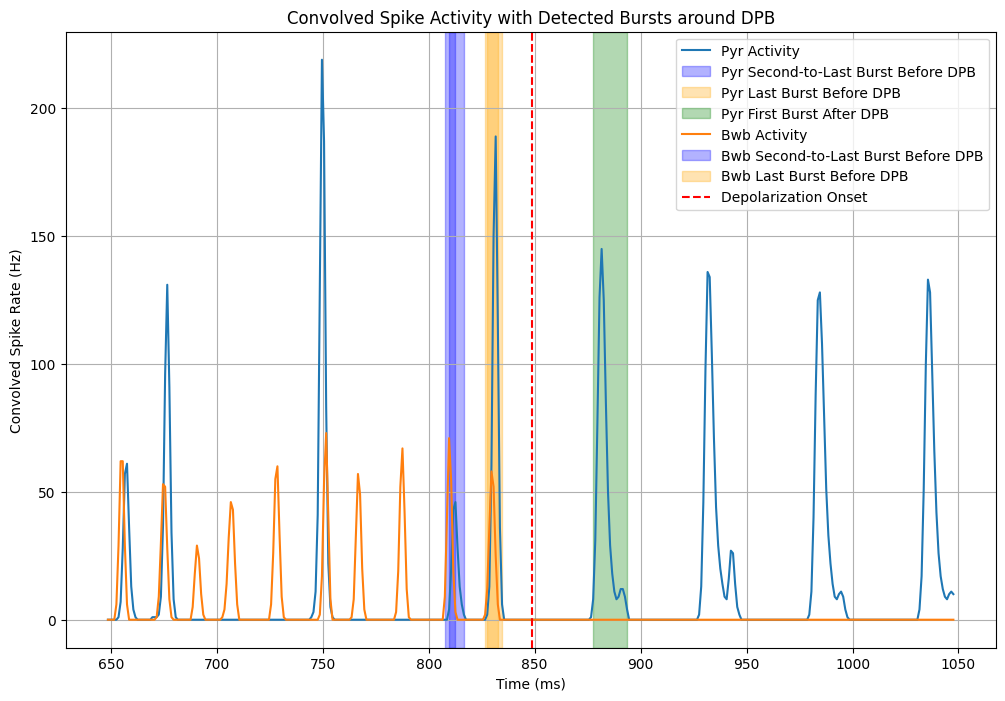

In [11]:
plot_convolved_activities_and_bursts(
    convolved_activities, burst_info, depolarization_onset
)

In [12]:
pkl_path = (
    "/home/Marc/Marc_network_sims/Results/all_conditions_burst_analysis_results.pkl"
)

try:
    with open(pkl_path, "rb") as file:
        results_all_conditions = pickle.load(file)
    print(f"Data loaded successfully from {pkl_path}.")
except Exception as e:
    print(f"Error loading the file {pkl_path}:", e)

Data loaded successfully from /home/Marc/Marc_network_sims/Results/all_conditions_burst_analysis_results.pkl.


Fix the new data hierarchy, or make one for each condition


In [13]:
print(results_all_conditions.keys())
results = results_all_conditions["gna_1.00_gk_1.00_noise_1.00"]
print(results.keys())

dict_keys(['gna_1.00_gk_1.00_noise_1.00', 'gna_0.80_gk_1.20_noise_1.00', 'gna_1.20_gk_0.80_noise_1.00', 'gna_0.80_gk_0.80_noise_1.00', 'gna_1.20_gk_1.20_noise_1.00'])
dict_keys(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14'])


In [14]:
print(results["00"]["burst_info"])

{'Pyr': {'last_burst_before_dpb': (826.6, 836.6, 54), 'second_last_burst_before_dpb': (808.6, 817.1, 14), 'first_burst_after_dpb': (876.1, 894.1, 53)}, 'Bwb': {'last_burst_before_dpb': (826.1, 834.6, 18), 'second_last_burst_before_dpb': (806.1, 814.1, 19), 'first_burst_after_dpb': None}}


In [15]:
def calculate_mean_and_std_activities(aligned_activities):
    """
    Calculates the mean and standard deviation of aligned activities across trials.
    Assumes that all activities are aligned to the same relative start time.
    """
    # Determine the longest time range to standardize activity lengths
    max_length = max(len(times) for times, _ in aligned_activities)
    standardized_activities = np.full((len(aligned_activities), max_length), np.nan)

    for i, (times, activities) in enumerate(aligned_activities):
        standardized_activities[i, : len(activities)] = activities

    # Calculate mean and standard deviation, ignoring NaNs
    mean_activities = np.nanmean(standardized_activities, axis=0)
    std_activities = np.nanstd(standardized_activities, axis=0)

    # Use the longest time array for x-axis
    longest_times = aligned_activities[
        np.argmax([len(times) for times, _ in aligned_activities])
    ][0]

    return longest_times, mean_activities, std_activities

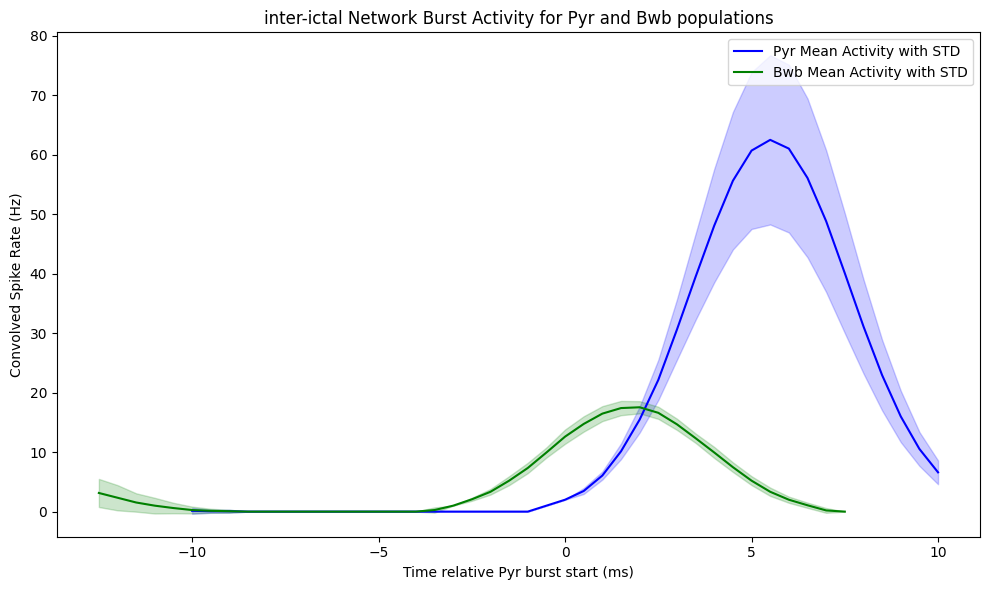

In [16]:
def align_inter_ictal_bursts(results, cell_types, pre_post_margin=10):
    """
    Aligns the second to last burst before the depolarization onset for specified cell types
    to the start time of the second to last Pyramidal (Pyr) burst, with a specified margin for context.
    This assumes that 'Pyr' is included in the cell_types and that it serves as the reference for alignment.
    """
    aligned_activities = {cell_type: [] for cell_type in cell_types}

    for trial in results.values():
        burst_info_pyr = trial["burst_info"]["Pyr"]
        second_last_before_pyr = burst_info_pyr.get("second_last_burst_before_dpb")

        # Ensure there's a second to last burst for Pyr cells to use as a reference
        if second_last_before_pyr:
            start_time_pyr = second_last_before_pyr[0]  # Reference time for alignment

            for cell_type in cell_types:
                burst_info = trial["burst_info"][cell_type]
                second_last_before = burst_info.get("second_last_burst_before_dpb")
                conv_times, conv_activities = trial["convolved_activities"][cell_type]

                if second_last_before:
                    # Align to the specific burst's start time if available
                    align_start_time = second_last_before[0]
                else:
                    # Fallback to aligning using the Pyr start time if specific burst info is missing
                    align_start_time = start_time_pyr

                # Adjust the segment extraction to be around the Pyr's second last burst start time
                start_time = max(0, align_start_time - pre_post_margin)
                end_time = align_start_time + pre_post_margin

                segment_mask = (conv_times >= start_time) & (conv_times <= end_time)
                times_segment = (
                    conv_times[segment_mask] - start_time_pyr
                )  # Aligning to second last Pyr burst start
                activities_segment = conv_activities[segment_mask]

                aligned_activities[cell_type].append(
                    (times_segment, activities_segment)
                )

    return aligned_activities


# Cell types to consider
cell_types = ["Pyr", "Bwb"]

# Align activities based on the second to last Pyr burst start times
aligned_activities_2nd_to_last = align_inter_ictal_bursts(results, cell_types)

# Calculate mean and std for both cell types
mean_std_activities_2nd_to_last = {}
for cell_type in ["Pyr", "Bwb"]:
    mean_std_activities_2nd_to_last[cell_type] = calculate_mean_and_std_activities(
        aligned_activities_2nd_to_last[cell_type]
    )

# Plotting
plt.figure(figsize=(10, 6))

# Define colors for each cell type
colors = {"Pyr": "blue", "Bwb": "green"}

# Loop through each cell type to plot
for cell_type, color in colors.items():
    times, mean_activities, std_activities = mean_std_activities_2nd_to_last[cell_type]

    plt.plot(
        times, mean_activities, label=f"{cell_type} Mean Activity with STD", color=color
    )
    plt.fill_between(
        times,
        mean_activities - std_activities,
        mean_activities + std_activities,
        color=color,
        alpha=0.2,
    )

plt.title("inter-ictal Network Burst Activity for Pyr and Bwb populations")
plt.xlabel("Time relative Pyr burst start (ms)")
plt.ylabel("Convolved Spike Rate (Hz)")
plt.legend()
plt.tight_layout()
plt.show()

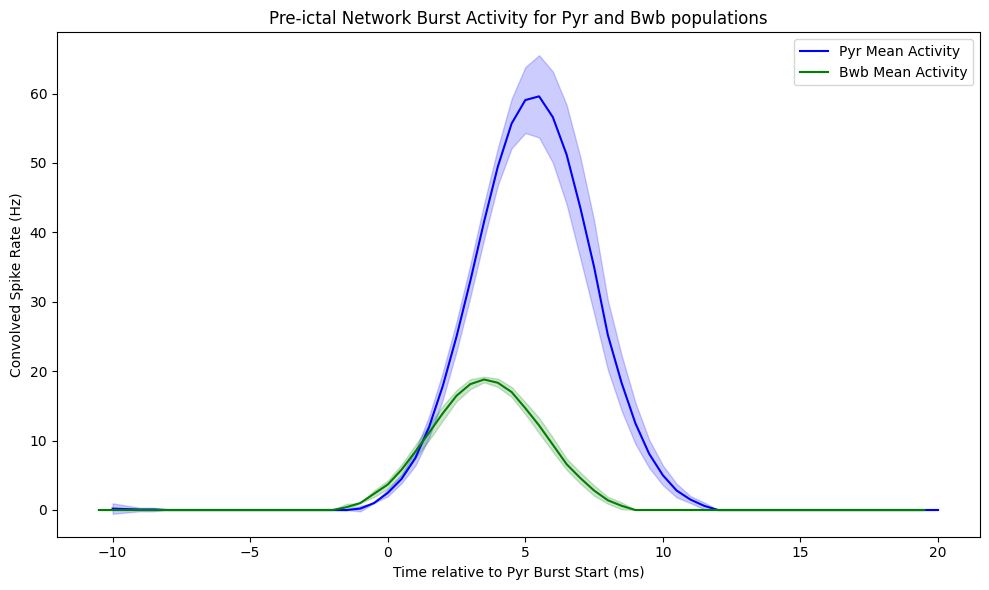

In [17]:
def align_pre_ictal_bursts(results, cell_types, pre_post_margin=10, post_margin=20):
    """
    Aligns the last burst before the depolarization onset for each trial for specified cell types
    to the start time of the last Pyramidal (Pyr) burst, with specified margins for context.
    This ensures a dynamic adjustment for the segment extraction to include additional context after the burst,
    according to the post_margin parameter.

    Args:
        results (dict): The trial results including burst information and convolved activities.
        cell_types (list): A list of cell types to align activities for.
        pre_post_margin (int): The margin before the burst start time to include as context.
        post_margin (int): The margin after the burst end time or depolarization onset to reduce cutoff.
    """
    aligned_activities = {cell_type: [] for cell_type in cell_types}

    for trial in results.values():
        burst_info_pyr = trial["burst_info"]["Pyr"]
        last_before_pyr = burst_info_pyr["last_burst_before_dpb"]
        depo_onset = trial["depolarization_onset"]

        if last_before_pyr:
            start_time_pyr = last_before_pyr[0]  # Reference time for alignment

            for cell_type in cell_types:
                burst_info = trial["burst_info"][cell_type]
                last_before = burst_info["last_burst_before_dpb"]
                conv_times, conv_activities = trial["convolved_activities"][cell_type]

                if last_before:
                    align_start_time = last_before[0]
                else:
                    align_start_time = start_time_pyr

                # Adjust the segment extraction to include the pre margin and extend beyond the burst with post_margin
                start_time = max(0, align_start_time - pre_post_margin)
                # Ensure end_time does not exceed the depo_onset and considers post_margin
                end_time = min(align_start_time + post_margin, depo_onset)

                segment_mask = (conv_times >= start_time) & (conv_times <= end_time)
                times_segment = (
                    conv_times[segment_mask] - start_time_pyr
                )  # Aligning to last Pyr burst start
                activities_segment = conv_activities[segment_mask]

                aligned_activities[cell_type].append(
                    (times_segment, activities_segment)
                )

    return aligned_activities


# Cell types to consider
cell_types = ["Pyr", "Bwb"]

# Assuming 'results' is your data structure containing trial data
aligned_activities_pre_dpb = align_pre_ictal_bursts(results, cell_types)

# Calculate mean and std for both cell types directly without needing to adjust them post-hoc
mean_std_activities_pre_dpb = {}
for cell_type in ["Pyr", "Bwb"]:
    mean_std_activities_pre_dpb[cell_type] = calculate_mean_and_std_activities(
        aligned_activities_pre_dpb[cell_type]
    )

# Plotting
plt.figure(figsize=(10, 6))

# Define colors for each cell type for consistency
colors = {"Pyr": "blue", "Bwb": "green"}

# Loop through each cell type to plot
for cell_type, color in colors.items():
    times, mean_activities, std_activities = mean_std_activities_pre_dpb[cell_type]

    # Plot mean activities
    plt.plot(times, mean_activities, label=f"{cell_type} Mean Activity", color=color)

    # Plotting the standard deviation area
    plt.fill_between(
        times,
        mean_activities - std_activities,
        mean_activities + std_activities,
        color=color,
        alpha=0.2,
    )


plt.title("Pre-ictal Network Burst Activity for Pyr and Bwb populations")
plt.xlabel("Time relative to Pyr Burst Start (ms)")
plt.ylabel("Convolved Spike Rate (Hz)")
plt.legend()
plt.tight_layout()
plt.show()

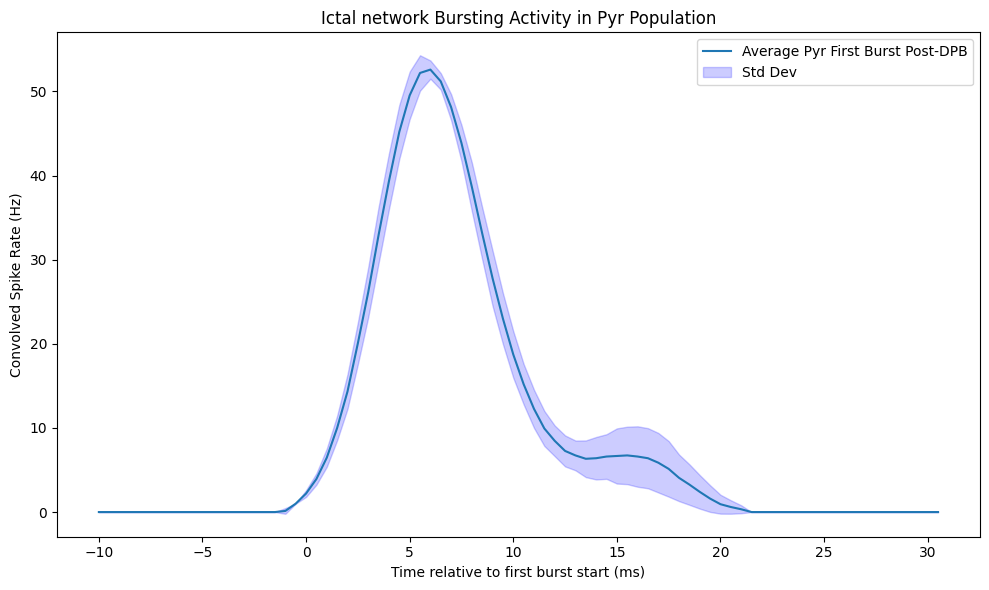

In [18]:
def align_ictal_burst(results, cell_type, pre_post_margin=10):
    """
    Aligns the first burst after the depolarization onset for each trial for a specified cell type to their start time.
    Adds a margin around the burst for context.
    """
    aligned_activities = []

    for trial in results.values():
        burst_info = trial["burst_info"][cell_type]
        first_after = burst_info["first_burst_after_dpb"]
        conv_times, conv_activities = trial["convolved_activities"][cell_type]

        if first_after is not None:
            # Extract the relevant segment with a margin
            start_time = max(0, first_after[0] - pre_post_margin)
            end_time = first_after[1] + pre_post_margin

            segment_mask = (conv_times >= start_time) & (conv_times <= end_time)
            times_segment = (
                conv_times[segment_mask] - first_after[0]
            )  # Aligning to first burst start
            activities_segment = conv_activities[segment_mask]

            aligned_activities.append((times_segment, activities_segment))

    return aligned_activities


# Assuming 'results' is your data structure containing trial data
aligned_activities_ictal_burst = align_ictal_burst(results, "Pyr")
# Assuming 'aligned_activities_pyr_first_burst' contains your aligned activities for Pyr cells
longest_times, mean_activities, std_activities = calculate_mean_and_std_activities(
    aligned_activities_ictal_burst
)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(longest_times, mean_activities, label="Average Pyr First Burst Post-DPB")
plt.fill_between(
    longest_times,
    mean_activities - std_activities,
    mean_activities + std_activities,
    color="blue",
    alpha=0.2,
    label="Std Dev",
)

plt.title("Ictal network Bursting Activity in Pyr Population")
plt.xlabel("Time relative to first burst start (ms)")
plt.ylabel("Convolved Spike Rate (Hz)")
plt.legend()
plt.tight_layout()
plt.show()

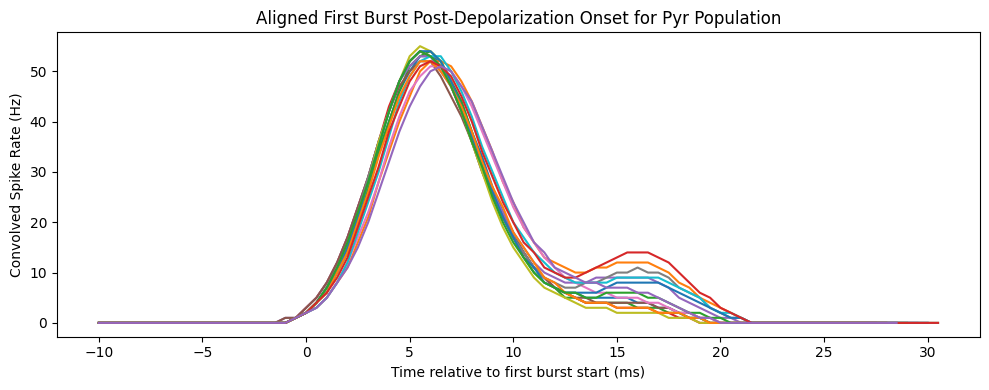

In [19]:
# Plotting
plt.figure(figsize=(10, 4))
for times, activities in aligned_activities_ictal_burst:
    plt.plot(times, activities, label="Pyr First Burst Post-DPB")

plt.title("Aligned First Burst Post-Depolarization Onset for Pyr Population")
plt.xlabel("Time relative to first burst start (ms)")
plt.ylabel("Convolved Spike Rate (Hz)")
plt.tight_layout()
plt.show()

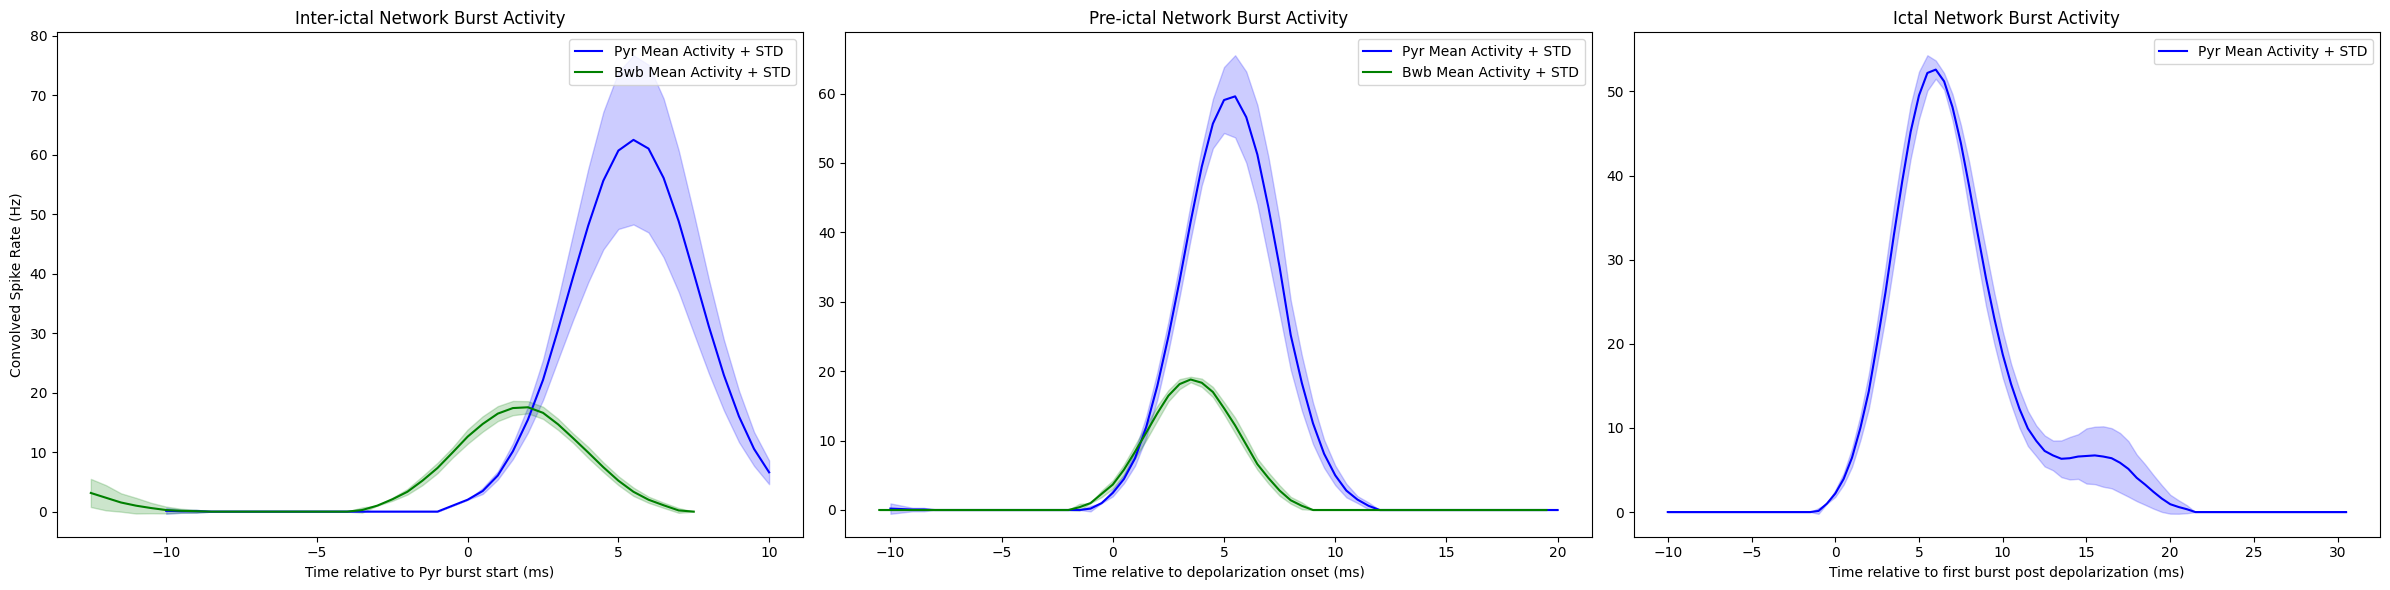

In [20]:
# Set up a figure for subplots
fig, axes = plt.subplots(
    1, 3, figsize=(24, 6)
)  # 1 row, 3 columns, and custom figure size

# Define colors for each cell type for consistency across plots
colors = {"Pyr": "blue", "Bwb": "green"}

# Inter-ictal Plot
# Assuming mean_std_activities for inter-ictal are prepared similarly to your last plot's preparation
for cell_type, color in colors.items():
    times, mean_activities, std_activities = mean_std_activities_2nd_to_last[
        cell_type
    ]  # For inter-ictal
    axes[0].plot(
        times, mean_activities, label=f"{cell_type} Mean Activity + STD", color=color
    )
    axes[0].fill_between(
        times,
        mean_activities - std_activities,
        mean_activities + std_activities,
        color=color,
        alpha=0.2,
    )

axes[0].set_title("Inter-ictal Network Burst Activity")
axes[0].set_xlabel("Time relative to Pyr burst start (ms)")
axes[0].set_ylabel("Convolved Spike Rate (Hz)")
axes[0].legend()

# Pre-ictal Plot
# Assuming mean_std_activities for pre-ictal are prepared from your 'aligned_activities_last_burst' for each cell type
for cell_type, color in colors.items():
    times, mean_activities, std_activities = mean_std_activities_pre_dpb[
        cell_type
    ]  # For pre-ictal
    axes[1].plot(
        times, mean_activities, label=f"{cell_type} Mean Activity + STD", color=color
    )
    axes[1].fill_between(
        times,
        mean_activities - std_activities,
        mean_activities + std_activities,
        color=color,
        alpha=0.2,
    )

axes[1].set_title("Pre-ictal Network Burst Activity")
axes[1].set_xlabel("Time relative to depolarization onset (ms)")
axes[1].legend()

# Ictal Plot
# Assuming 'aligned_activities_ictal_burst' and its processing for the ictal plot
# Here you would use the results from your 'calculate_mean_and_std_activities' directly for the ictal activity
times, mean_activities, std_activities = calculate_mean_and_std_activities(
    aligned_activities_ictal_burst
)
axes[2].plot(
    times, mean_activities, label="Pyr Mean Activity + STD", color=colors["Pyr"]
)
axes[2].fill_between(
    times,
    mean_activities - std_activities,
    mean_activities + std_activities,
    color=colors["Pyr"],
    alpha=0.2,
)

axes[2].set_title("Ictal Network Burst Activity")
axes[2].set_xlabel("Time relative to first burst post depolarization (ms)")
axes[2].legend()

plt.tight_layout()
plt.show()

Data loaded successfully from /home/Marc/Marc_network_sims/Results/all_conditions_burst_analysis_results.pkl.


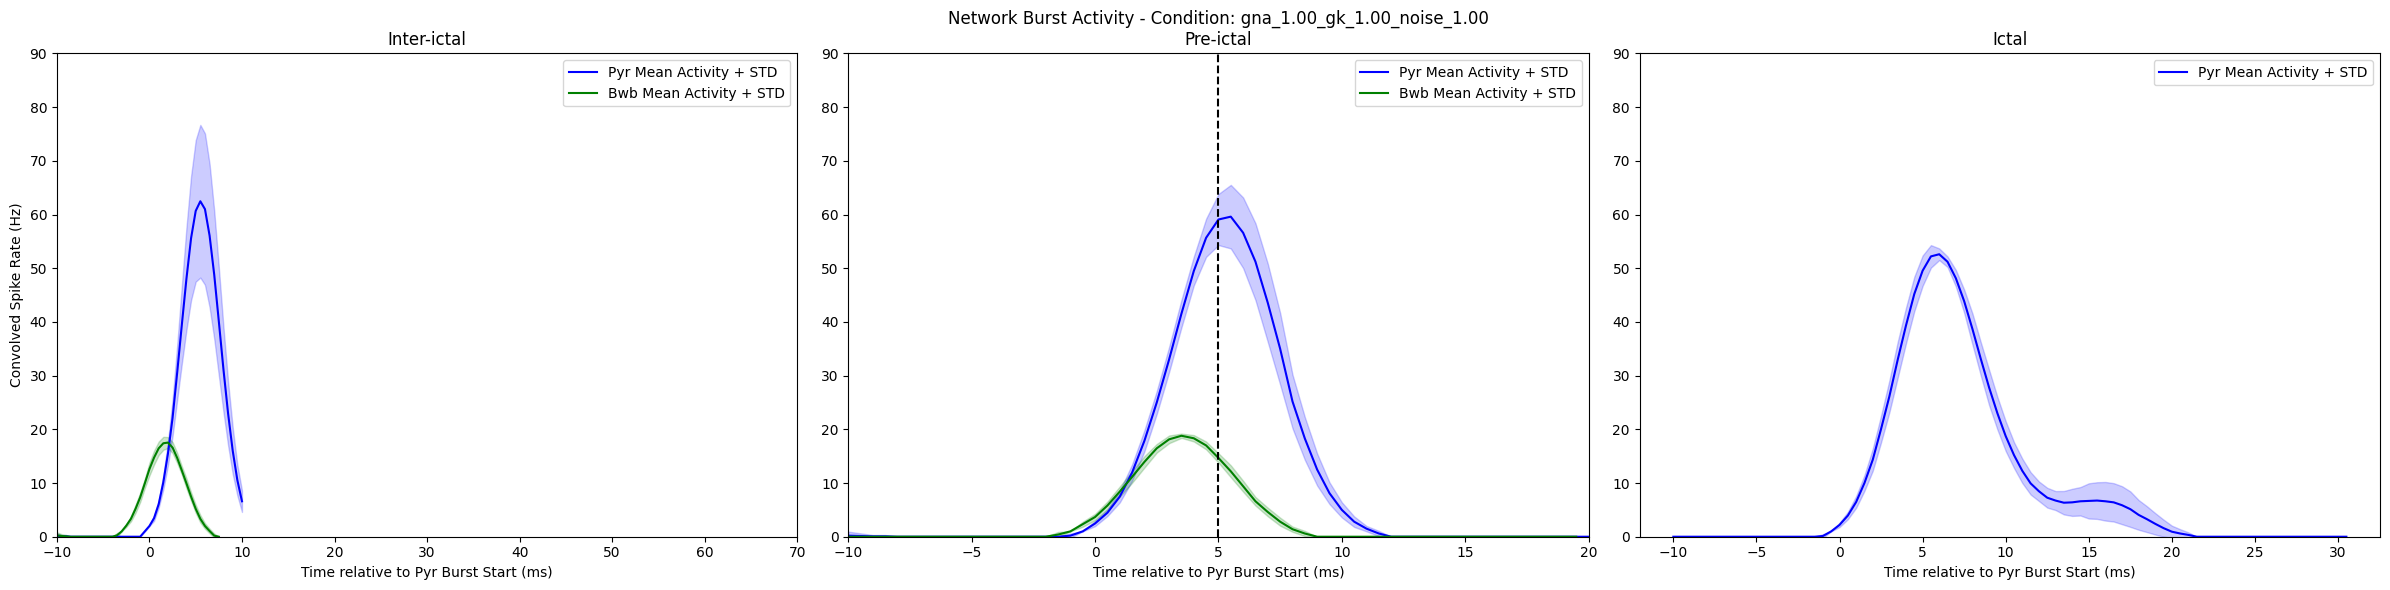

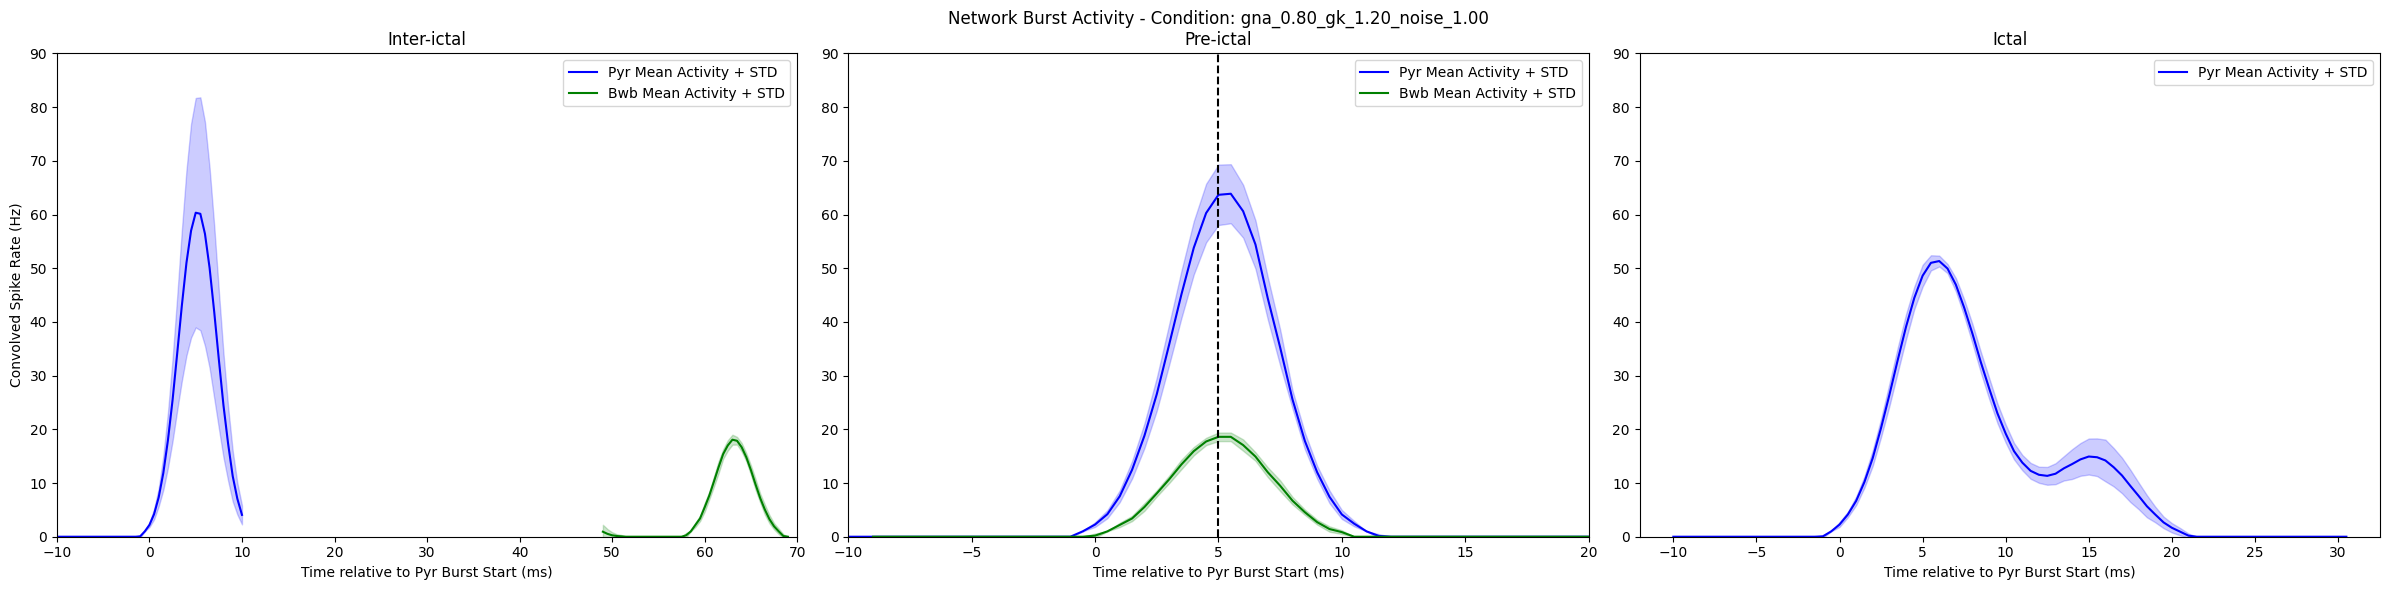

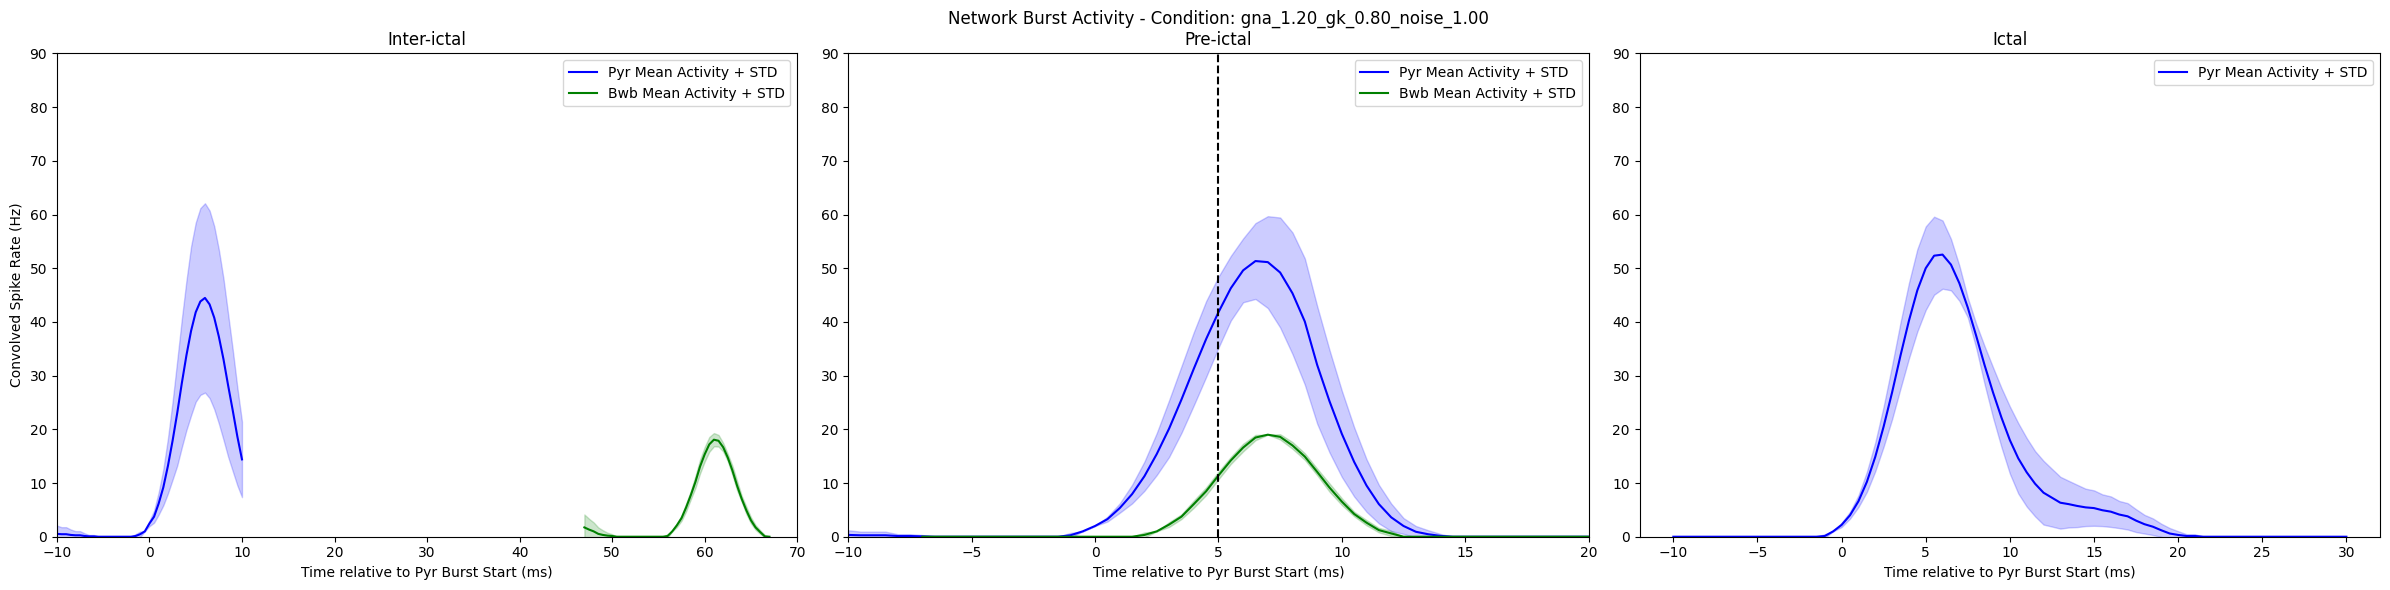

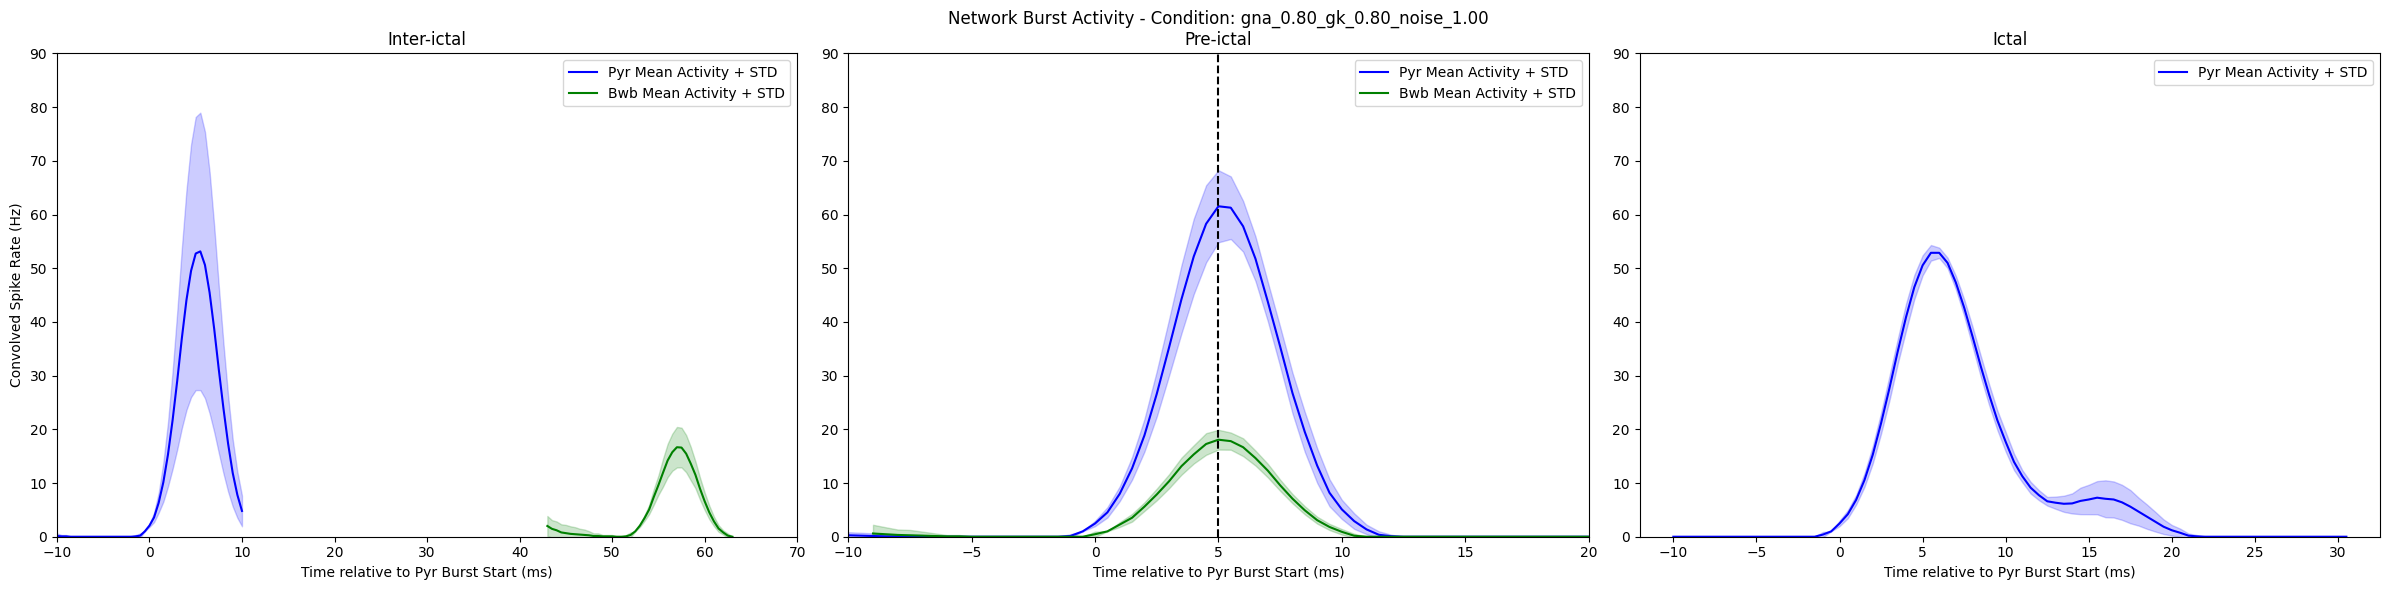

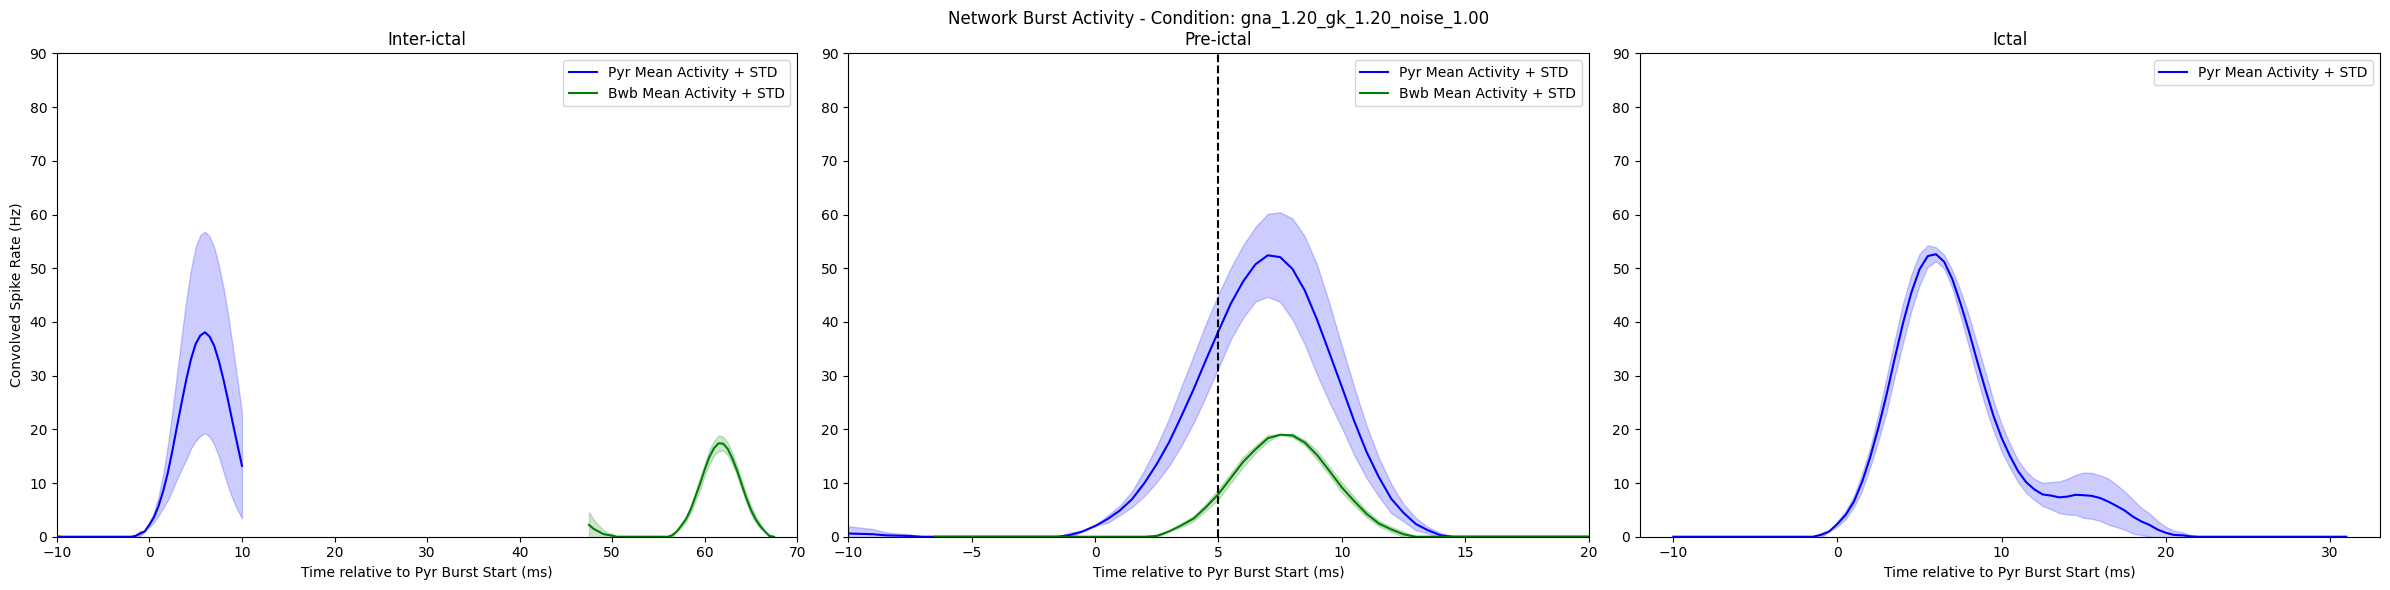

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Conditions defined previously
conditions = [
    ("1.00", "1.00"),  # Baseline
    ("0.80", "1.20"),
    ("1.20", "0.80"),
    ("0.80", "0.80"),
    ("1.20", "1.20"),
]

# Load results
pkl_path = (
    "/home/Marc/Marc_network_sims/Results/all_conditions_burst_analysis_results.pkl"
)
try:
    with open(pkl_path, "rb") as file:
        results_all_conditions = pickle.load(file)
    print(f"Data loaded successfully from {pkl_path}.")
except Exception as e:
    print(f"Error loading the file {pkl_path}:", e)

# Assume align_inter_ictal_bursts, align_pre_ictal_bursts, align_ictal_burst, and calculate_mean_and_std_activities functions are defined


def plot_all_together_for_condition(condition_key, results):
    # Extract condition-specific results
    results_condition = results.get(condition_key)
    if results_condition is None:
        print(f"No results found for condition {condition_key}.")
        return

    # Align and calculate for each burst type
    aligned_activities_inter_ictal = align_inter_ictal_bursts(
        results_condition, cell_types
    )
    aligned_activities_pre_ictal = align_pre_ictal_bursts(
        results_condition, ["Pyr", "Bwb"]
    )
    aligned_activities_ictal = align_ictal_burst(results_condition, "Pyr")

    mean_std_activities_inter_ictal = {
        cell_type: calculate_mean_and_std_activities(
            aligned_activities_inter_ictal[cell_type]
        )
        for cell_type in ["Pyr", "Bwb"]
    }
    mean_std_activities_pre_ictal = {
        cell_type: calculate_mean_and_std_activities(
            aligned_activities_pre_ictal[cell_type]
        )
        for cell_type in ["Pyr", "Bwb"]
    }
    (
        times_ictal,
        mean_activities_ictal,
        std_activities_ictal,
    ) = calculate_mean_and_std_activities(aligned_activities_ictal)

    # Plot all together, now including the condition_key in each subplot title
    fig, axes = plt.subplots(
        1, 3, figsize=(24, 6)
    )  # 1 row, 3 columns, and custom figure size
    colors = {"Pyr": "blue", "Bwb": "green"}

    # Define y-limit for all plots
    fixed_ylim = (0, 90)

    # Inter-ictal Plot
    for cell_type, color in colors.items():
        times, mean_activities, std_activities = mean_std_activities_inter_ictal[
            cell_type
        ]
        axes[0].plot(
            times,
            mean_activities,
            label=f"{cell_type} Mean Activity + STD",
            color=color,
        )
        axes[0].fill_between(
            times,
            mean_activities - std_activities,
            mean_activities + std_activities,
            color=color,
            alpha=0.2,
        )
    axes[0].set_title("Inter-ictal")
    axes[0].set_xlabel("Time relative to Pyr Burst Start (ms)")
    axes[0].set_ylabel("Convolved Spike Rate (Hz)")
    axes[0].set_xlim(-10, 70)
    axes[0].set_ylim(fixed_ylim)
    axes[0].legend()

    # Pre-ictal Plot
    for cell_type, color in colors.items():
        times, mean_activities, std_activities = mean_std_activities_pre_ictal[
            cell_type
        ]
        axes[1].plot(
            times,
            mean_activities,
            label=f"{cell_type} Mean Activity + STD",
            color=color,
        )
        axes[1].fill_between(
            times,
            mean_activities - std_activities,
            mean_activities + std_activities,
            color=color,
            alpha=0.2,
        )
    # Adding a black dashed horizontal line at y=5
    axes[1].axvline(x=5, color="black", linestyle="--")
    axes[1].set_title(f"Network Burst Activity - Condition: {condition_key}\nPre-ictal")
    axes[1].set_xlabel("Time relative to Pyr Burst Start (ms)")
    axes[1].set_xlim(-10, 20)
    axes[1].set_ylim(fixed_ylim)
    axes[1].legend()

    # Ictal Plot
    axes[2].plot(
        times_ictal,
        mean_activities_ictal,
        label="Pyr Mean Activity + STD",
        color=colors["Pyr"],
    )
    axes[2].fill_between(
        times_ictal,
        mean_activities_ictal - std_activities_ictal,
        mean_activities_ictal + std_activities_ictal,
        color=colors["Pyr"],
        alpha=0.2,
    )
    axes[2].set_title("Ictal")
    axes[2].set_xlabel("Time relative to Pyr Burst Start (ms)")
    axes[2].set_ylim(fixed_ylim)
    axes[2].legend()

    plt.tight_layout()
    plt.show()


# Iterate over conditions and plot
for gNa, gK in conditions:
    condition_key = f"gna_{gNa}_gk_{gK}_noise_1.00"
    plot_all_together_for_condition(condition_key, results_all_conditions)

## TODO

- To do: align all plots to pyr burst onset.
- To do: divide the pyr activity by 4 (800 pyr cells, 200 basket).
- Maybe add a vertical line at x =5 in the middle plot.
- Fix the titles and Y-axes.
